Student Name: Paul Minogue

Student ID: 21196354

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression, VarianceThreshold
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

In [2]:
df = pd.read_csv("./insurance.csv")

First, some basic exploratory analysis is done to see how tidy and clean the data is.

In [3]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [4]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [5]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [6]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [8]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [9]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

This is good. &ensp; There are no missing categorical attributes and the only numerical attribute with instances of zero is `children`, in which a case of zero is a meaningful value.

Outliers are now examined using boxplots.

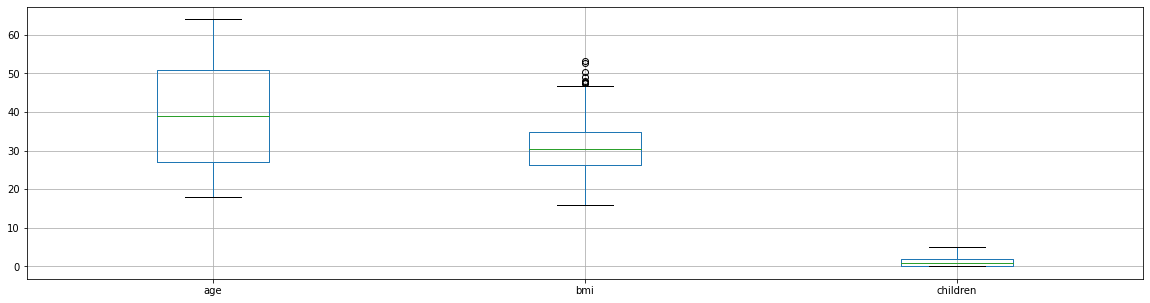

In [10]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

`bmi` has some outliers but they don't look too extreme. &ensp; Nevertheless, it will be scaled using a log transformation.

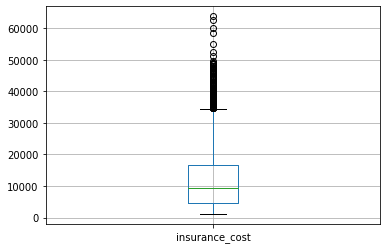

In [11]:
df.boxplot(column=['insurance_cost'])
plt.show()

`insurance_cost` has a large number of outliers, but given that it's the target variable, it will not be scaled. &ensp; The consensus is not unanimous on whether or not the target variable should be scaled, but in trying to fit model with and without scaling, there appeared to be a negligible difference.

## Data Preparation

`bmi` is now scaled.

In [12]:
df['bmi'] = np.log(df['bmi'])

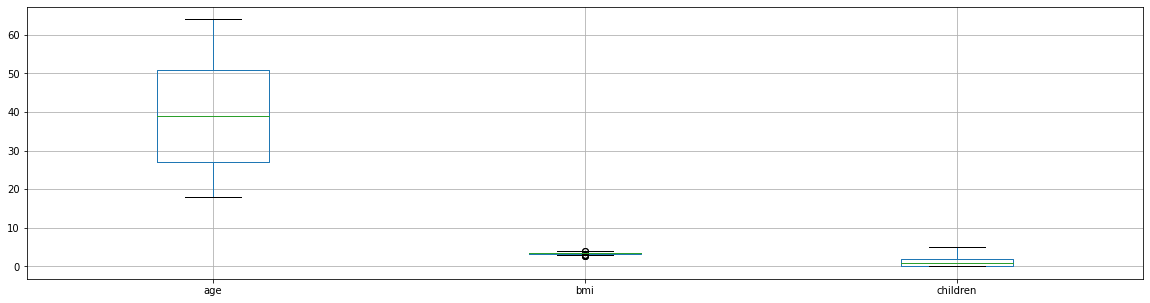

In [13]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

All of the numerical variables are now free of outliers.

The attributes `gender`, `smoker`, and `region` are now one-hot encoded. &ensp; None of these attribures have a natural ordering to them, which simplifies the thought process.

In [14]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        drop_first=True)

An attempt was made to convert the `age` attribute to age categories, but it actually worsened the performance of all of the models, so it wasn't done in the end. &ensp;  I believe if the dataset was much larger, this may have worked better.

In [15]:
# plt.rcParams["axes.labelsize"] = 14
# sns.histplot(data=df, x=df['age'], bins='auto')
# plt.ylabel('Frequency of ages')
# plt.show()

In [16]:
# bins=[0, 25, 35, 45, 55, 100]
# labels=['18-25', '26-35', '36-45', '46-55', '55+']

In [17]:
# df['age'] = pd.cut(df['age'], bins, labels=labels)
# df = pd.get_dummies(df, columns=['age'], drop_first=True)

In [18]:
df.head()

age       bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  3.519573         1      1725.55230            1           0   
1   18  3.529297         0      1137.01100            1           0   
2   18  3.270139         0      2198.18985            0           0   
3   18  3.654935         2      3393.35635            0           0   
4   18  3.573048         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [19]:
preprocess_pipeline = make_pipeline(StandardScaler(with_mean=False))

In [20]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search

### Random Forest Pipeline

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor())])

In [22]:
N_FEATURES_OPTIONS = [3, 5, 7]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
N_ESTIMATORS = [8, 10, 12, 14]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_ESTIMATORS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_ESTIMATORS
    }, 
    {
        'reduce_dim': [SelectKBest(mutual_info_regression)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        #'reduce_dim__threshold': ['median', 'mean'],
        'regresson__n_estimators': N_ESTIMATORS
    }, 
    {
        'reduce_dim': [VarianceThreshold()],
        'reduce_dim__threshold': [0, 0.001, 0.01, 0.1],
        'regresson__n_estimators': N_ESTIMATORS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=7), 'reduce_dim__n_features_to_select': 7, 'regresson__max_depth': 4, 'regresson__n_estimators': 14}


### Linear Regression Pipeline

In [23]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [24]:
N_FEATURES_OPTIONS = [3, 5, 7]
#FIT_INTERCEPT = [True, False]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    }, 
    {
        'reduce_dim': [SelectKBest(mutual_info_regression)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        #'reduce_dim__threshold': [0.001, 0.01, 0.1],
    }, 
    {
        'reduce_dim': [VarianceThreshold()],
        'reduce_dim__threshold': [0, 0.001, 0.01, 0.1]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.736:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=7), 'reduce_dim__n_features_to_select': 7}


### SGD Regressor Pipeline

In [25]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SGDRegressor())])

In [26]:
N_FEATURES_OPTIONS = [3, 5, 7]
ALPHA = [0.005, 0.001, 0.05, 0.01]
LOSS_FUNCTION = ['squared_error', 'squared_epsilon_insensitive']
REGULARIZER = ['l1', 'l2', 'elasticnet']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA,
        'regresson__loss': LOSS_FUNCTION,
        'regresson__penalty': REGULARIZER
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA,
        'regresson__loss': LOSS_FUNCTION,
        'regresson__penalty': REGULARIZER
    }, 
    {
        'reduce_dim': [SelectKBest(mutual_info_regression)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA,
        'regresson__loss': LOSS_FUNCTION,
        #'reduce_dim__threshold': [0.001, 0.01, 0.1],
        'regresson__penalty': REGULARIZER
    }, 
    {
        'reduce_dim': [VarianceThreshold()],
        'reduce_dim__threshold': [0, 0.001, 0.01, 0.1],
        'regresson__alpha': ALPHA,
        'regresson__loss': LOSS_FUNCTION,
        'regresson__penalty': REGULARIZER
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SGD_best_params = search.best_params_
SGD_best_model = search.best_estimator_

Best CV score = 0.734:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=7), 'reduce_dim__n_components': 7, 'regresson__alpha': 0.01, 'regresson__loss': 'squared_epsilon_insensitive', 'regresson__penalty': 'elasticnet'}


## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [27]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [28]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SGD_mse, SGD_mae, SGD_r2 = evaluate_model(X_test, y_test, SGD_best_model)

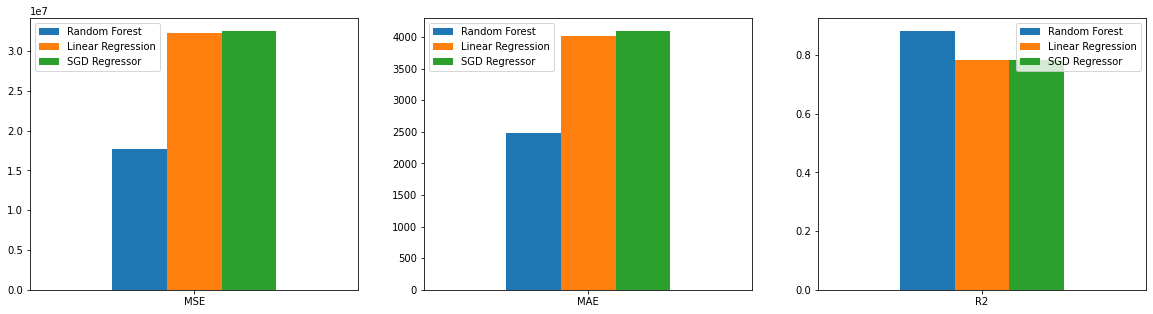

In [29]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse,
                       'SGD Regressor': SGD_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae,
                       'SGD Regressor': SGD_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2,
                      'SGD Regressor': SGD_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The `Random Forest` model seemed to outperform both `Linear Regression` and the `Stochastic Gradient Regressor` quite considerably in terms of Mean Squared Error and Mean Absolute Error. &ensp; It also performed best in terms of R-Squared Error. &ensp; The difference between LR and SGD across all of the error metrics was negligible. &ensp; Adding more parameter options didn't seem to change the difference between them at all. &ensp; Random Forest just seems the best option out of the three on this dataset by a considerable margin.

The two addional dimensionality reduction methods tried were `SelectKBest` and `VarianceThreshold`. &ensp; Both use feature selection, which is essentially a subcategory within dimensionality reduction, where features are dropped instead of being merged into new features.

SelectKBest assigns importance to each feature through a specific attribute and then removes features if their importance is below a provided threshold parameter (mean of the feature importances by default). &ensp; VarianceThreshold also works based on a threshold and as its name suggests, it removes features whose variance doesn’t meet that threshold.

## Train a Final Model

In [30]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     LR_best_params.get('reduce_dim'),
                     RandomForestRegressor(**transform(LR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)